# Cutout a region in the sub-myocard

Tim delineated the patch and the myocard.
Let's use these two regions and cut out a defined subregion from them.

In [1]:
%load_ext pycodestyle_magic

In [237]:
%pycodestyle_on --ignore E501

In [238]:
# %flake8_off

In [239]:
import platform
import os
import glob
import pandas
import numpy
import imageio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import skimage.filters
import dask
import dask_image.imread
from tqdm.auto import tqdm
import math

In [240]:
# Import our own parsing functions which we've added as submodule
from BrukerSkyScanLogfileRuminator.parsing_functions import *

In [ ]:
# Set dask temporary folder
# Do this before creating a client: https://stackoverflow.com/a/62804525/323100
if 'Linux' in platform.system():
    tmp = os.path.join(os.sep, 'media', 'habi', 'FastSSD')
elif 'Darwin' in platform.system():
    import tempfile
    tmp = tempfile.gettempdir()
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\')
    else:
        tmp = os.path.join('D:\\')
dask.config.set({'temporary_directory': os.path.join(tmp, 'tmp')})

In [242]:
from dask.distributed import Client
client = Client()
# Use the same scheduler as in the preview notebook
# https://stackoverflow.com/a/68670238
# client = Client(scheduler_file='dask_scheduler.json')

2024-08-29 12:15:31,415 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-from-zarr-8d8d4c7aa3961597cadbe298a5494b38' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x7f0330d2cb80>, (<zarr.core.Array (449, 2452, 2452) uint8 read-only>,), {})
new run_spec: (<function execute_task at 0x7f0330d2cb80>, (<zarr.core.Array (449, 2452, 2452) uint8 read-only>,), {})
old token: ('tuple', [('913ceb5b5beb463a9010ec0790bc30002ca34164', []), ('tuple', [('ed97bdb092c1a5cc90508b3ce05ebc259c9872d4', ['05fe405753166f125559e7c9ac558654f107c7e9'])]), ('dict', [])])
new token: ('tupl

In [243]:
# Start dask client and tell where we can see what it does
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:44211/status,
Dashboard: http://127.0.0.1:44211/status,Workers: 8
Total threads: 32,Total memory: 125.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34885,Workers: 8
Dashboard: http://127.0.0.1:44211/status,Total threads: 32
Started: Just now,Total memory: 125.79 GiB
Comm: tcp://127.0.0.1:45233,Total threads: 4
Dashboard: http://127.0.0.1:35343/status,Memory: 15.72 GiB
Nanny: tcp://127.0.0.1:44071,


In [ ]:
# Ignore warnings in the notebook
#import warnings
#warnings.filterwarnings("ignore")

In [ ]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
scale = 1
plt.rcParams['figure.figsize'] = (16/scale, 9/scale)  # Size up figures a bit
plt.rcParams['figure.dpi'] = 300  # Increase dpi

In [ ]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [248]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)

In [249]:
def get_git_hash():
    """
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    """
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git', '--git-dir', os.path.join(os.getcwd(), '.git'),
                        'rev-parse', '--short', '--verify', 'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [250]:
# What are we working with?
the_current_git_hash = get_git_hash()
print('We are working with version %s of the analyis notebook.'
      % the_current_git_hash)

In [251]:
# Generate the output folder
# Including the git hash, so we (potentially) have different versions of all the images we generate
OutputDir = os.path.join('Output', the_current_git_hash)
os.makedirs(OutputDir, exist_ok=True)

2:80: E501 line too long (99 > 79 characters)


In [ ]:
# Different locations if running either on Linux or Windows
if 'anaklin' in platform.node():
    FastSSD = True
else:
    FastSSD = False
FastSSD = True
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'FastSSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
elif 'Darwin' in platform.system():
    BasePath = os.path.join('/Volumes/2TBSSD/')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('E:\\')
        else:
            BasePath = os.path.join('D:\\', 'Results')
Root = os.path.join(BasePath, 'Hearts Melly')
print('We are loading all the data from %s' % Root)

In [253]:
# The three cardinal directions
directions = ['Axial', 'Sagittal', 'Coronal']

In [254]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [255]:
# Get *all* log files, unsorted but fast
# This sould get us all data that is on disk
Data['LogFile'] = [os.path.join(root, name)
                   for root, dirs, files in os.walk(Root)
                   for name in files
                   if name.endswith((".log"))]

In [256]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [ ]:
# Get rid of all non-rec logfiles
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:
        Data.drop([c], inplace=True)
    elif 'ctan.log' in row.LogFile:
        Data.drop([c], inplace=True)
    elif 'rectmp.log' in row.LogFile:
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [258]:
# Drop all folders we don't want
for c, row in Data.iterrows():
    if 'Rat' not in row.Folder:
        Data.drop([c], inplace=True)
    elif 'Rat4' in row.Folder:
        Data.drop([c], inplace=True)
    elif 'Rat5' in row.Folder:
        Data.drop([c], inplace=True)
    elif 'Test' in row.Folder:
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

11:80: E501 line too long (92 > 79 characters)
15:80: E501 line too long (93 > 79 characters)


In [ ]:
# Generate us some meaningful colums
Data['Samplename'] = [l[len(Root)+1:].split(os.sep)[0] for l in Data['LogFile']]
Data['Scan'] = ['.'.join(l[len(Root)+1:].split(os.sep)[1:-1]) for l in Data['LogFile']]

In [ ]:
# Read in animals list from Ludovic
AnimalTable = pandas.read_excel('Animals.xlsx',
                                engine='openpyxl',
                                header=None,
                                names=['Animal', 'Gender', '', 'Experiment', 'Timepoint'])

In [262]:
# Merge in data from animals table
for c, rowdata in Data.iterrows():
    for d, rowanimals in AnimalTable.iterrows():
        if str(rowanimals.Animal) in rowdata.Samplename:
            Data.at[c, 'Animal'] = rowanimals.Animal
            Data.at[c, 'Experiment'] = rowanimals.Experiment
            Data.at[c, 'Timepoint'] = rowanimals.Timepoint
            Data.at[c, 'Gender'] = rowanimals.Gender

In [263]:
# Convert some columns to int
Data['Animal'] = Data['Animal'].astype(int)
Data['Timepoint'] = Data['Timepoint'].astype(int)

In [264]:
Data.sort_values(['Samplename', 'Scan'], inplace=True)
Data.reset_index(drop=True, inplace=True)

In [265]:
print('For %s rats we have %s folders containing a scan on disk' % (len(Data.Animal.unique()), len(Data)))

1:80: E501 line too long (106 > 79 characters)


In [266]:
Data.Samplename.unique()

array(['Rat60', 'Rat61', 'Rat62', 'Rat63', 'Rat64', 'Rat65', 'Rat66',
       'Rat67', 'Rat68', 'Rat69', 'Rat70', 'Rat71', 'Rat79', 'Rat80',
       'Rat81', 'Rat82', 'Rat83', 'Rat84', 'Rat87', 'Rat88', 'Rat90'],
      dtype=object)

In [267]:
Data.Animal.unique()

array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 79, 80, 81, 82, 83,
       84, 87, 88, 90])

In [268]:
# Exclusion from Tims visual inspection
# R63
# R65
# R66
# R70
# exclude = [63, 65, 66, 70]

In [269]:
# Exclusion from Tims visual inspection for 2214 scans
# R67: "verstrahlt"
# R70: No tachosil
# exclude = [63, 65, 66, 70]

In [270]:
# Drop samples which should be excluded
# Based on https://stackoverflow.com/a/13851602
# for c,row in Data.iterrows():
#     for ex in exclude:
#         if str(ex) in row.Samplename:
#             Data.drop(c, inplace=True)
# Data.reset_index(drop=True, inplace=True)

In [271]:
# # "Filter" to subset that we want
# for c,row in Data.iterrows():
#     if 'cu_10um' not in row.Scan:
#         Data.drop(c, inplace=True)
# Data.reset_index(drop=True, inplace=True)

In [272]:
# Tim delineated both the patch and myocard region
# We thus duplicate the dataframe to load all regions correctly
Data = pandas.concat([Data] * 2, ignore_index=True)
# First sort by animal, then by scan so the VOI colum filling works as intended
Data.sort_values(['Samplename', 'Scan'], inplace=True)
# Fill actual VOI column with alternating values
Data['VOI'] = ['myocard', 'patch'] * (len(Data)//2)

In [273]:
Data.head(n=8)

,LogFile,Folder,Samplename,Scan,Animal,Experiment,Timepoint,Gender,VOI
0,/media/habi/Fast_SSD/Hearts Melly/Rat60/cu_10u...,/media/habi/Fast_SSD/Hearts Melly/Rat60/cu_10u...,Rat60,cu_10um.rec,60,V+P,7,F,myocard
33,/media/habi/Fast_SSD/Hearts Melly/Rat60/cu_10u...,/media/habi/Fast_SSD/Hearts Melly/Rat60/cu_10u...,Rat60,cu_10um.rec,60,V+P,7,F,patch
1,/media/habi/Fast_SSD/Hearts Melly/Rat61/cu_10u...,/media/habi/Fast_SSD/Hearts Melly/Rat61/cu_10u...,Rat61,cu_10um.rec,61,V+P,7,F,myocard
34,/media/habi/Fast_SSD/Hearts Melly/Rat61/cu_10u...,/media/habi/Fast_SSD/Hearts Melly/Rat61/cu_10u...,Rat61,cu_10um.rec,61,V+P,7,F,patch
2,/media/habi/Fast_SSD/Hearts Melly/Rat62/cu_10u...,/media/habi/Fast_SSD/Hearts Melly/Rat62/cu_10u...,Rat62,cu_10um.rec,62,F,7,F,myocard
35,/media/habi/Fast_SSD/Hearts Melly/Rat62/cu_10u...,/media/habi/Fast_SSD/Hearts Melly/Rat62/cu_10u...,Rat62,cu_10um.rec,62,F,7,F,patch
3,/media/habi/Fast_SSD/Hearts Melly/Rat63/2214_7...,/media/habi/Fast_SSD/Hearts Melly/Rat63/2214_7...,Rat63,2214_7.5um_Al1mm.rec,63,F,7,F,myocard
36,/media/habi/Fast_SSD/Hearts Melly/Rat63/2214_7...,/media/habi/Fast_SSD/Hearts Melly/Rat63/2214_7...,Rat63,2214_7.5um_Al1mm.rec,63,F,7,F,patch


In [274]:
Data.tail(n=8)

,LogFile,Folder,Samplename,Scan,Animal,Experiment,Timepoint,Gender,VOI
29,/media/habi/Fast_SSD/Hearts Melly/Rat87/2214_7...,/media/habi/Fast_SSD/Hearts Melly/Rat87/2214_7...,Rat87,2214_7.5um_Al1mm.rec,87,V,7,M,myocard
62,/media/habi/Fast_SSD/Hearts Melly/Rat87/2214_7...,/media/habi/Fast_SSD/Hearts Melly/Rat87/2214_7...,Rat87,2214_7.5um_Al1mm.rec,87,V,7,M,patch
30,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,Rat88,2214_7.5um_Al1mm.rec,88,V+P,7,M,myocard
63,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,Rat88,2214_7.5um_Al1mm.rec,88,V+P,7,M,patch
31,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,Rat88,2214_7.5um_Al1mm.rec_reslice,88,V+P,7,M,myocard
64,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,Rat88,2214_7.5um_Al1mm.rec_reslice,88,V+P,7,M,patch
32,/media/habi/Fast_SSD/Hearts Melly/Rat90/2214_7...,/media/habi/Fast_SSD/Hearts Melly/Rat90/2214_7...,Rat90,2214_7.5um_Al1mm.rec,90,tachosil only,7,M,myocard
65,/media/habi/Fast_SSD/Hearts Melly/Rat90/2214_7...,/media/habi/Fast_SSD/Hearts Melly/Rat90/2214_7...,Rat90,2214_7.5um_Al1mm.rec,90,tachosil only,7,M,patch


In [275]:
# Generate us a consistent folder name
Data['VOIFolder'] = [os.path.join(os.path.dirname(f),
                                  'voi_' + v) for f, v in zip(Data['Folder'], Data['VOI'])]

3:80: E501 line too long (91 > 79 characters)


In [276]:
# Look for .roi files from Tim inside these generated folders above
Data['VOIFile'] = [sorted(glob.glob(os.path.join(f, '*.roi'))) for f in Data['VOIFolder']]

2:80: E501 line too long (90 > 79 characters)


In [277]:
# Drop folders where no VOI file was found
# https://stackoverflow.com/a/13851602
Data.drop(Data[Data['VOIFile'].map(len) < 1].index, inplace=True)
Data.reset_index(drop=True, inplace=True)

In [278]:
print('For %s rats we have %s folders containing a scan on disk' %
      (len(Data.Animal.unique()), len(Data)))

In [279]:
Data.head()

,LogFile,Folder,Samplename,Scan,Animal,Experiment,Timepoint,Gender,VOI,VOIFolder,VOIFile
0,/media/habi/Fast_SSD/Hearts Melly/Rat60/cu_10u...,/media/habi/Fast_SSD/Hearts Melly/Rat60/cu_10u...,Rat60,cu_10um.rec,60,V+P,7,F,myocard,/media/habi/Fast_SSD/Hearts Melly/Rat60/cu_10u...,[/media/habi/Fast_SSD/Hearts Melly/Rat60/cu_10...
1,/media/habi/Fast_SSD/Hearts Melly/Rat60/cu_10u...,/media/habi/Fast_SSD/Hearts Melly/Rat60/cu_10u...,Rat60,cu_10um.rec,60,V+P,7,F,patch,/media/habi/Fast_SSD/Hearts Melly/Rat60/cu_10u...,[/media/habi/Fast_SSD/Hearts Melly/Rat60/cu_10...
2,/media/habi/Fast_SSD/Hearts Melly/Rat61/cu_10u...,/media/habi/Fast_SSD/Hearts Melly/Rat61/cu_10u...,Rat61,cu_10um.rec,61,V+P,7,F,myocard,/media/habi/Fast_SSD/Hearts Melly/Rat61/cu_10u...,[/media/habi/Fast_SSD/Hearts Melly/Rat61/cu_10...
3,/media/habi/Fast_SSD/Hearts Melly/Rat61/cu_10u...,/media/habi/Fast_SSD/Hearts Melly/Rat61/cu_10u...,Rat61,cu_10um.rec,61,V+P,7,F,patch,/media/habi/Fast_SSD/Hearts Melly/Rat61/cu_10u...,[/media/habi/Fast_SSD/Hearts Melly/Rat61/cu_10...
4,/media/habi/Fast_SSD/Hearts Melly/Rat62/cu_10u...,/media/habi/Fast_SSD/Hearts Melly/Rat62/cu_10u...,Rat62,cu_10um.rec,62,F,7,F,myocard,/media/habi/Fast_SSD/Hearts Melly/Rat62/cu_10u...,[/media/habi/Fast_SSD/Hearts Melly/Rat62/cu_10...


In [280]:
# See if there are missing images in the folders
Data['VOIImages'] = [sorted(glob.glob(os.path.join(f, '*.png'))) for f in Data['VOIFolder']]
Data['Number of VOI slices'] = [len(vs) for vs in Data['VOIImages']]

2:80: E501 line too long (92 > 79 characters)


In [281]:
for c, file in enumerate(Data['VOIFile']):
    if len(file):
        if Data['Number of VOI slices'][c] <= 222:
            print(Data['Samplename'][c], Data['Scan'][c],
                  Data['VOIFile'][c][0], 'has less than 222 exported files')

In [282]:
print('We habe %s folders of %s samples to look into' % (len(Data), len(Data.Samplename.unique())))

1:80: E501 line too long (99 > 79 characters)


Now we want to get the necessary data into the dataframe

In [283]:
# Get information we need from the lofiles
Data['Scanner'] = [scanner(log) for log in Data['LogFile']]
Data['Voxelsize'] = [pixelsize(log) for log in Data['LogFile']]

In [284]:
# Always sort experiment in *this* order
DisplayOrderExperiments = sorted(Data.Experiment.unique())
ordering = [1, 2, 0, 3]
DisplayOrderExperiments[:] = [DisplayOrderExperiments[i] for i in ordering]
print('The display order of the experiments is %s' % DisplayOrderExperiments)

In [285]:
def color_based_on_timepoint(tp):
    '''Unique color for each timpeoint'''
    if tp == 7:
        return seaborn.color_palette()[0]
    elif tp == 28:
        return seaborn.color_palette()[1]

In [286]:
# Generate color (scheme), based on experiment time
Data['ColorTimepoint'] = [color_based_on_timepoint(tp) for tp in Data.Timepoint]

2:80: E501 line too long (80 > 79 characters)


In [287]:
def color_based_on_scanner(scn):
    '''Unique color depending on machine we've scanned'''
    if str(1272) in scn:
        return seaborn.color_palette()[2]
    else:
        return seaborn.color_palette()[3]

In [288]:
# Generate color (scheme), based on experiment time
Data['ColorScanner'] = [color_based_on_scanner(scn) for scn in Data.Scanner]

In [289]:
def color_based_on_experiment(exp):
    '''Unique color for each experiment value'''
    if 'V+P' in exp:
        return seaborn.color_palette(n_colors=4)[0]
    elif 'F' in exp:
        return seaborn.color_palette(n_colors=4)[1]
    elif 'tachosil' in exp:
        return seaborn.color_palette(n_colors=4)[2]
    else:
        return seaborn.color_palette(n_colors=4)[3]

In [290]:
# Generate color (siterrows based on experiment type
Data['ColorExperiment'] = [color_based_on_experiment(name) for name in Data.Experiment]

2:80: E501 line too long (87 > 79 characters)


Now we can actually start to load some data.
At first we load the ROI stacks exported by Tim.
He exported the data into `voi_patch` and `voi_myocard` folders, consistently.
We simply load *all* PNG files in there, and convert this data to rechunked .zarr arrays for fast access from disk.

In [291]:
# Convert all VOI slices into a rechunked DASK array on disk for faster access
# Partially based on http://stackoverflow.com/a/39195332/323100
# and on /LungMetastasis/HighResolutionScanAnalysis.ipynb
Data['OutputNameVOI'] = [os.path.join(os.path.dirname(f),
                                      '%s.%s.voi_%s.zarr' % (sample,
                                                             scan,
                                                             voi)) for f, sample, scan, voi in zip(Data.Folder,
                                                                                                   Data.Samplename,
                                                                                                   Data.Scan,
                                                                                                   Data.VOI)]
for c, row in tqdm(Data.iterrows(), desc='Reading VOIs', total=len(Data)):
    if not os.path.exists(row['OutputNameVOI']):
        print('%2s/%s: Reading %0.f VOI slices from %s and saving to %s' % (c + 1,
                                                                            len(Data),
                                                                            row['Number of VOI slices'],
                                                                            row['VOIFolder'][len(Root)+1:],
                                                                            row['OutputNameVOI'][len(Root)+1:]))
        VOI = dask_image.imread.imread(os.path.join(row['VOIFolder'], '*.png'))
        # Rechunking (to 'auto' size) is slow, but we only need to do it once and
        # further reads of the data are then much faster.
        VOI[:, :, :, 0].rechunk('auto').to_zarr(row['OutputNameVOI'])

Reading VOIs:   0%|          | 0/44 [00:00<?, ?it/s]

7:80: E501 line too long (111 > 79 characters)
8:80: E501 line too long (115 > 79 characters)
9:80: E501 line too long (109 > 79 characters)
10:80: E501 line too long (109 > 79 characters)
13:80: E501 line too long (82 > 79 characters)
14:80: E501 line too long (86 > 79 characters)
15:80: E501 line too long (104 > 79 characters)
16:80: E501 line too long (107 > 79 characters)
17:80: E501 line too long (112 > 79 characters)
19:80: E501 line too long (81 > 79 characters)


Do the same for the ROI *extent*.
We saved out the patch and myocard ROIs with BatMan in CTAN as `ExportROIs.ctl` in the root folder of the Neoangiogenese project.
Like so we do not have to extrapolate their extent in the notebook here.
They are consistently saved into the `rec` folder as *binary* `*.bmp` files in `BinaryROI` (patch) or `BinaryROI(1)` (myocard).
We now load them below.

In [300]:
# Convert all VOI slices into a rechunked DASK array on disk for faster access
# Partially based on http://stackoverflow.com/a/39195332/323100
# and on /LungMetastasis/HighResolutionScanAnalysis.ipynb
Data['OutputNameVOI_Binary'] = [os.path.join(os.path.dirname(f),
                                             '%s.%s.voi_%s.binary.zarr' % (sample,
                                                                           scan,
                                                                           voi)) for f, sample, scan, voi in zip(Data.Folder,
                                                                                                                 Data.Samplename,
                                                                                                                 Data.Scan,
                                                                                                                 Data.VOI)]
for c, row in tqdm(Data.iterrows(), desc='Reading VOIs', total=len(Data)):
    if not os.path.exists(row['OutputNameVOI_Binary']):
        if 'patch' in row.VOI:
            binaryROIpath = os.path.join(os.path.split(row['LogFile'])[0], 'BinaryROI')
        else:
            binaryROIpath = os.path.join(os.path.split(row['LogFile'])[0], 'BinaryROI(1)')
        print('%2s/%s: Reading all .bmp slices from %s/ and saving to %s' % (c + 1,
                                                                             len(Data),
                                                                             binaryROIpath[len(Root)+1:],
                                                                             row['OutputNameVOI_Binary'][len(Root)+1:]))
        try:
            VOI = dask_image.imread.imread(os.path.join(binaryROIpath, '*.bmp'))
            # Rechunking (to 'auto' size) is slow, but we only need to do it once and
            # further reads of the data are then much faster.
            VOI.rechunk('auto').to_zarr(row['OutputNameVOI_Binary'])
        except:
            print('\tCannot read images for %s' % binaryROIpath[len(Root)+1:])
            print('\tIf that is Rat88/2214_7.5um_Al1mm/rec you can just continue, otherwise you will have to investigate')

Reading VOIs:   0%|          | 0/44 [00:00<?, ?it/s]

5:80: E501 line too long (82 > 79 characters)
6:80: E501 line too long (80 > 79 characters)
7:80: E501 line too long (125 > 79 characters)
8:80: E501 line too long (129 > 79 characters)
9:80: E501 line too long (123 > 79 characters)
10:80: E501 line too long (123 > 79 characters)
14:80: E501 line too long (87 > 79 characters)
16:80: E501 line too long (90 > 79 characters)
17:80: E501 line too long (83 > 79 characters)
18:80: E501 line too long (87 > 79 characters)
19:80: E501 line too long (105 > 79 characters)
20:80: E501 line too long (120 > 79 characters)
22:80: E501 line too long (80 > 79 characters)
23:80: E501 line too long (85 > 79 characters)
26:9: E722 do not use bare 'except'
28:80: E501 line too long (122 > 79 characters)


In [301]:
# binarized = dask.array.from_zarr(Data['OutputNameVOI_Binary'][0])

In [302]:
# binarized[333].compute()

In [303]:
# img = dask.array.from_zarr(Data['OutputNameVOI'][0])

In [304]:
# img[333].compute()

In [305]:
# masked = dask.array.ma.masked_where(dask.array.invert(binarized), img.astype('uint64'))

1:80: E501 line too long (89 > 79 characters)


In [306]:
# masked[333].compute()

In [307]:
# dask.array.nanmean(binarized).compute()

In [308]:
# dask.array.nanmean(masked).compute()

In [309]:
# dask.array.nanmean(img).compute()

In [310]:
# slice = 456
# plt.subplot(131)
# plt.imshow(img[slice], vmax=32)

# plt.subplot(132)
# plt.imshow(binarized[slice])

# plt.subplot(133)
# plt.imshow(masked[slice], vmax=32)

# plt.show()

In [311]:
# Load the VOI images a zarr arrays
Patches = [dask.array.from_zarr(file) for file in Data[Data.VOI == 'patch']['OutputNameVOI']]
Myocards = [dask.array.from_zarr(file) for file in Data[Data.VOI == 'myocard']['OutputNameVOI']]

2:80: E501 line too long (93 > 79 characters)
3:80: E501 line too long (96 > 79 characters)


Now that we have the patches and pizza-slices (with patch, called myocard) loaded, we can calculate the only-myocard part.

In [312]:
# Generate some dummy data, clear it and append it to dataframe for the MSP VOIs
_ = pandas.DataFrame()
_ = Data[Data['VOI'] == 'myocard'].loc[:]
_['VOI'] = _['VOI'].replace(['myocard'], ['myocard_sans_patch'])
_.loc[:, ('VOIFolder', 'VOIFile', 'VOIImages', 'OutputNameVOI', 'Number of VOI slices')] = numpy.nan
UpDatedData = pandas.concat((Data, _))
Data = UpDatedData.copy(deep=True)
Data.sort_values(['Samplename', 'Scan'], inplace=True)
Data.reset_index(drop=True, inplace=True)

1:80: E501 line too long (80 > 79 characters)
5:80: E501 line too long (100 > 79 characters)


In [313]:
Data[(Data['Animal'] == 88)]

,LogFile,Folder,Samplename,Scan,Animal,Experiment,Timepoint,Gender,VOI,VOIFolder,VOIFile,VOIImages,Number of VOI slices,Scanner,Voxelsize,ColorTimepoint,ColorScanner,ColorExperiment,OutputNameVOI,OutputNameVOI_Binary
57,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,Rat88,2214_7.5um_Al1mm.rec,88,V+P,7,M,myocard,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,[/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_...,[/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_...,1078.0,SkyScan 2214,7.500482,"(0.12156862745098039, 0.4666666666666667, 0.70...","(0.8392156862745098, 0.15294117647058825, 0.15...","(0.12156862745098039, 0.4666666666666667, 0.70...",/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...
58,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,Rat88,2214_7.5um_Al1mm.rec,88,V+P,7,M,patch,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,[/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_...,[/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_...,1078.0,SkyScan 2214,7.500482,"(0.12156862745098039, 0.4666666666666667, 0.70...","(0.8392156862745098, 0.15294117647058825, 0.15...","(0.12156862745098039, 0.4666666666666667, 0.70...",/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...
59,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,Rat88,2214_7.5um_Al1mm.rec,88,V+P,7,M,myocard_sans_patch,NaN,NaN,NaN,NaN,SkyScan 2214,7.500482,"(0.12156862745098039, 0.4666666666666667, 0.70...","(0.8392156862745098, 0.15294117647058825, 0.15...","(0.12156862745098039, 0.4666666666666667, 0.70...",NaN,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...
60,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,Rat88,2214_7.5um_Al1mm.rec_reslice,88,V+P,7,M,myocard,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,[/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_...,[/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_...,1078.0,SkyScan 2214,7.500482,"(0.12156862745098039, 0.4666666666666667, 0.70...","(0.8392156862745098, 0.15294117647058825, 0.15...","(0.12156862745098039, 0.4666666666666667, 0.70...",/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...
61,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,Rat88,2214_7.5um_Al1mm.rec_reslice,88,V+P,7,M,patch,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,[/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_...,[/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_...,1078.0,SkyScan 2214,7.500482,"(0.12156862745098039, 0.4666666666666667, 0.70...","(0.8392156862745098, 0.15294117647058825, 0.15...","(0.12156862745098039, 0.4666666666666667, 0.70...",/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...
62,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,Rat88,2214_7.5um_Al1mm.rec_reslice,88,V+P,7,M,myocard_sans_patch,NaN,NaN,NaN,NaN,SkyScan 2214,7.500482,"(0.12156862745098039, 0.4666666666666667, 0.70...","(0.8392156862745098, 0.15294117647058825, 0.15...","(0.12156862745098039, 0.4666666666666667, 0.70...",NaN,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...


In [509]:
# Drop the non-resliced data from Rat88
Data = Data.drop(Data[(Data['Animal'] == 88) & (Data['Scan'] == '2214_7.5um_Al1mm.rec')].index)
Data = Data.reset_index(drop=True)

2:80: E501 line too long (95 > 79 characters)


In [510]:
Data[(Data['Animal'] == 88)]

,LogFile,Folder,Samplename,Scan,Animal,Experiment,Timepoint,Gender,VOI,VOIFolder,...,OutputNameSlab_binarized,GrayValueAlongSlab,GrayValueAlongSlabNormalized,GrayValueAlongSlab_trimmed_edges,GrayValueAlongSlab_trimmed_edgesNormalized,GrayValueAlongSlab_fully_trimmed,XAxisScale_Pixelsize,GrayValueAlongSlabMax,SlabLength,GrayValueAlongSlab_fully_trimmedNormalized
54,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,Rat88,2214_7.5um_Al1mm.rec_reslice,88,V+P,7,M,myocard,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,...,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,"[--, --, --, --, --, --, --, --, --, --, --, -...","[--, --, --, --, --, --, --, --, --, --, --, -...","[236, 3244, 7134, 12186, 17791, 23883, 30119, ...","[0.00016061874273220675, 0.0026256247536428083...","[236, 3244, 7134, 12186, 17791, 23883, 30119, ...","[0.0, 0.007500482, 0.015000964, 0.022501446, 0...",1220321,11.475737,"[0.00016061874273220675, 0.0026256247536428083..."
55,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,Rat88,2214_7.5um_Al1mm.rec_reslice,88,V+P,7,M,patch,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,...,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,"[--, --, --, --, --, --, --, --, --, --, --, -...","[--, --, --, --, --, --, --, --, --, --, --, -...","[338, 1886, 3772, 6704, 9555, 13415, 18938, 24...","[0.0003171842421344499, 0.0017916623407054062,...","[338, 1886, 3772, 6704, 9555, 13415, 18938, 24...","[0.0, 0.007500482, 0.015000964, 0.022501446, 0...",1049868,1.972627,"[0.0003171842421344499, 0.0017916623407054062,..."
56,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,Rat88,2214_7.5um_Al1mm.rec_reslice,88,V+P,7,M,myocard_sans_patch,NaN,...,/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...,"[--, --, --, --, --, --, --, --, --, --, --, -...","[--, --, --, --, --, --, --, --, --, --, --, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[18, 2161, 20366, 53860, 97429, 157731, 219872...","[0.0, 0.007500482, 0.015000964, 0.022501446, 0...",1220321,9.503111,"[0.0, 0.001756121225630028, 0.0166745472231077..."


In [511]:
# Save out 'myocard sans patch' raw data
# Regenerate output name for 'msp'
Data['OutputNameVOI'] = [os.path.join(os.path.dirname(f),
                                      '%s.%s.voi_%s.zarr' % (sample,
                                                             scan,
                                                             voi)) for f, sample, scan, voi in zip(Data.Folder,
                                                                                                   Data.Samplename,
                                                                                                   Data.Scan,
                                                                                                   Data.VOI)]
# https://stackoverflow.com/a/55437530/323100
for c, row in tqdm(enumerate(Data[Data['VOI'] == 'myocard_sans_patch'].iterrows()),
                   desc='Calculating MSP VOIs',
                   total=len(Data[Data['VOI'] == 'myocard_sans_patch'])):
    if not os.path.exists(row[1]['OutputNameVOI']):
        print('%2s/%s: Calculating MSP VOI and saving to %s' % (c + 1,
                                                                len(Data[Data['VOI'] == 'myocard_sans_patch']),
                                                                row[1]['OutputNameVOI'][len(Root)+1:]))
        MSP = dask.array.subtract(Myocards[c], Patches[c])
        MSP.rechunk('auto').to_zarr(row[1]['OutputNameVOI'])

Calculating MSP VOIs:   0%|          | 0/20 [00:00<?, ?it/s]

6:80: E501 line too long (111 > 79 characters)
7:80: E501 line too long (115 > 79 characters)
8:80: E501 line too long (109 > 79 characters)
9:80: E501 line too long (109 > 79 characters)
11:80: E501 line too long (83 > 79 characters)
16:80: E501 line too long (111 > 79 characters)
17:80: E501 line too long (103 > 79 characters)


In [512]:
Patches = [dask.array.from_zarr(file) for file in Data[Data.VOI == 'patch']['OutputNameVOI']]
Myocards = [dask.array.from_zarr(file) for file in Data[Data.VOI == 'myocard']['OutputNameVOI']]
MSP = [dask.array.from_zarr(file) for file in Data[Data.VOI == 'myocard_sans_patch']['OutputNameVOI']]

1:80: E501 line too long (93 > 79 characters)
2:80: E501 line too long (96 > 79 characters)
3:80: E501 line too long (102 > 79 characters)


In [513]:
# for file in Data[Data.VOI == 'patch']['OutputNameVOI_Binary']:
#     print(file)
#     dask.array.from_zarr(file)

In [319]:
# Load the VOI images a zarr arrays
Patches_Binary = [dask.array.from_zarr(file) for file in Data[Data.VOI == 'patch']['OutputNameVOI_Binary']]
Myocards_Binary = [dask.array.from_zarr(file) for file in Data[Data.VOI == 'myocard']['OutputNameVOI_Binary']]

2:80: E501 line too long (107 > 79 characters)
3:80: E501 line too long (110 > 79 characters)


In [320]:
# Patches_Binary[0][333].compute()

In [321]:
# dask.array.logical_xor(Patches_Binary[0][333], Myocards_Binary[0][333]).compute()

1:80: E501 line too long (83 > 79 characters)


In [322]:
# plt.subplot(131)
# plt.imshow(Patches_Binary[0][333])

# plt.subplot(132)
# plt.imshow(Myocards_Binary[0][333])

# plt.subplot(133)
# plt.imshow(dask.array.logical_xor(Myocards_Binary[0][333], Patches_Binary[0][333]))

# plt.show()

8:80: E501 line too long (85 > 79 characters)


In [323]:
# Write out 'myocard sans patch' binarized data
# Regenerate output name for 'msp'
Data['OutputNameVOI_Binary'] = [os.path.join(os.path.dirname(f),
                                             '%s.%s.voi_%s.binary.zarr' % (sample,
                                                                           scan,
                                                                           voi)) for f, sample, scan, voi in zip(Data.Folder,
                                                                                                                 Data.Samplename,
                                                                                                                 Data.Scan,
                                                                                                                 Data.VOI)]
# https://stackoverflow.com/a/55437530/323100
for c, row in tqdm(enumerate(Data[Data['VOI'] == 'myocard_sans_patch'].iterrows()),
                   desc='Calculating MSP VOIs',
                   total=len(Data[Data['VOI'] == 'myocard_sans_patch'])):
    if not os.path.exists(row[1]['OutputNameVOI_Binary']):
        print('%2s/%s: Calculating MSP VOI and saving to %s' % (c + 1,
                                                                len(Data[Data['VOI'] == 'myocard_sans_patch']),
                                                                row[1]['OutputNameVOI_Binary'][len(Root)+1:]))
        MSP_Binary = dask.array.logical_xor(Myocards_Binary[c], Patches_Binary[c])
        MSP_Binary.rechunk('auto').to_zarr(row[1]['OutputNameVOI_Binary'])

Calculating MSP VOIs:   0%|          | 0/21 [00:00<?, ?it/s]

4:80: E501 line too long (82 > 79 characters)
5:80: E501 line too long (80 > 79 characters)
6:80: E501 line too long (125 > 79 characters)
7:80: E501 line too long (129 > 79 characters)
8:80: E501 line too long (123 > 79 characters)
9:80: E501 line too long (123 > 79 characters)
11:80: E501 line too long (83 > 79 characters)
16:80: E501 line too long (111 > 79 characters)
17:80: E501 line too long (110 > 79 characters)
18:80: E501 line too long (82 > 79 characters)


In [324]:
# Load *all* VOIs
VOIs_raw = [dask.array.from_zarr(file) for file in Data['OutputNameVOI']]
VOIs_binarized = [dask.array.from_zarr(file) for file in Data['OutputNameVOI_Binary']]

3:80: E501 line too long (86 > 79 characters)


In [325]:
whichone = 11

In [326]:
print('Looking at %s/%s/%s' % (Data['Samplename'][whichone],
                               Data['Scan'][whichone],
                               Data['VOI'][whichone]))

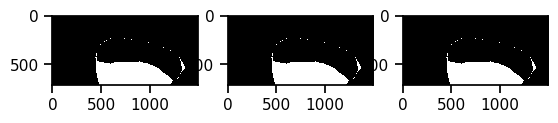

2:18: E231 missing whitespace after ','
2:20: E231 missing whitespace after ','
3:54: E231 missing whitespace after ','


In [327]:
for c, direction in enumerate(directions):
    plt.subplot(1, 3, c+1)
    plt.imshow(VOIs_binarized[whichone][100][400:1111,500:2000], vmax=0.25)
plt.show()

In [328]:
numpy.unique(VOIs_binarized[whichone][100][400:1111, 500:2000].compute())

array([False,  True])

In [329]:
# Get us the size of the data
Data['MiddleSliceNumber'] = [v.shape[0]//2 for v in VOIs_raw]

In [330]:
# # Now load MSPs from disk
MSP_Binary = [dask.array.from_zarr(file) for file in Data[Data.VOI == 'myocard_sans_patch']['OutputNameVOI_Binary']]

2:80: E501 line too long (116 > 79 characters)


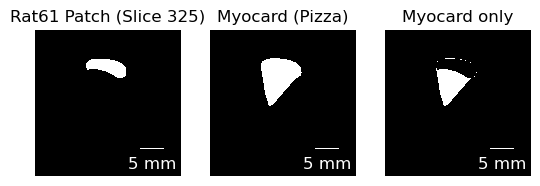

11:80: E501 line too long (80 > 79 characters)


In [331]:
whichsample = 3
whichslice = 128

plt.subplot(131)
plt.imshow(Patches_Binary[whichsample][Data['MiddleSliceNumber'][whichsample]])
plt.gca().add_artist(ScaleBar(Data['Voxelsize'][0], 'um'))
plt.axis('off')
plt.title('%s Patch (Slice %s)' % (Data['Samplename'][whichsample],
                                   Data['MiddleSliceNumber'][whichsample]))
plt.subplot(132)
plt.imshow(Myocards_Binary[whichsample][Data['MiddleSliceNumber'][whichsample]])
plt.title('Myocard (Pizza)')
plt.gca().add_artist(ScaleBar(Data['Voxelsize'][0], 'um'))
plt.axis('off')
plt.subplot(133)
plt.imshow(MSP_Binary[whichsample][Data['MiddleSliceNumber'][whichsample]])
plt.title('Myocard only')
plt.gca().add_artist(ScaleBar(Data['Voxelsize'][0], 'um'))
plt.axis('off')
plt.savefig(os.path.join(OutputDir, 'Binarized.png'))
plt.show()

In [332]:
# Get us the VOI volumes
# If we 'sum' the binarized VOIs, we get the number of True voxels, e.g. the extent of the drawn VOI
Data['VOIVolume'] = [dask.array.sum(v).compute() for v in VOIs_binarized]

2:80: E501 line too long (100 > 79 characters)


In [333]:
# dask.array.sum(VOIs_binarized[0][333]).compute()

In [334]:
# VOIs_raw[0]

In [335]:
# VOIs_binarized[0]

In [336]:
# for c, row in Data.iterrows():
#     print(c, row.Samplename, row.Scan, row.VOI)
#     plt.semilogy(mkh[c])
#     plt.xlim([0,255])
#     plt.title(os.path.join(os.path.dirname(Data[Data.VOI == row.VOI]['OutputNameVOI'][c][len(Root)+1:]), row.VOI))
#     plt.show()
#     print(80*'-')

In [ ]:
# for c, rec in enumerate(Reconstructions):
#     plt.semilogy(rh[c], label='%s/%s' % (Data.Samplename[c], Data.Scan[c]))
#     plt.xlim([0, 2**8])
#     plt.legend()
#     plt.show()

In [ ]:
# for c, row in Data[Data.VOI == 'myocard'].iterrows():
#     print(c, row.Samplename, row.Scan)
#     plt.semilogy(mkh[c], label='%s/%s' % (row.Samplename, row.Scan))
#     plt.xlim([0, 2**8])
#     plt.show()

In [ ]:
# for c, row in Data[Data.VOI == 'patch'].iterrows():
#     print(c, row.Samplename, row.Scan)
#     plt.semilogy(mkh[c], label='%s/%s' % (row.Samplename, row.Scan))
#     plt.xlim([0, 2**8])    
#     plt.show()

In [ ]:
# scale = 2
# plt.rcParams['figure.figsize'] = (16/scale, 9/scale)  # Size up figures a bit

In [ ]:
# Generate some dummy data, clear it and append it to dataframe for the MSP VOIs
_ = pandas.DataFrame()
_ = Data[Data.VOI == 'myocard']
_['VOI'].replace(['myocard'], 'myocard_sans_patch', inplace=True)
_.loc[:, ('VOIFolder', 'VOIFiles', 'OutputNameVOI', 'Number of VOI slices')] = ''
UpDatedData = pandas.concat((Data, _))
Data = UpDatedData.copy(deep=True)
Data.sort_values(['Samplename', 'Scan'], inplace=True)
Data.reset_index(drop=True, inplace=True)

In [ ]:
Data

In [ ]:
Data[Data['VOI'] == 'myocard_sans_patch']

In [ ]:
# Save 'myocard sans patch' data
Data['OutputNameVOI'] = [os.path.join(os.path.dirname(f),
                                      '%s.%s.voi_%s.zarr' % (sample,
                                                             scan,
                                                             voi)) for f, sample, scan, voi in zip(Data.Folder,
                                                                                                   Data.Samplename,
                                                                                                   Data.Scan,
                                                                                                   Data.VOI)]
# https://stackoverflow.com/a/55437530/323100
for c, row in tqdm(enumerate(Data[Data['VOI'] == 'myocard_sans_patch'].iterrows()),
                            desc='Calculating MSP VOIs',
                            total=len(Data[Data['VOI'] == 'myocard_sans_patch'])):
    if not os.path.exists(row[1]['OutputNameVOI']):
        print('%2s/%s: Calculating MSP VOI and saving to %s' % (c + 1,
                                                                len(Data[ Data['VOI'] == 'myocard_sans_patch']),
                                                                row[1]['OutputNameVOI'][len(Root)+1:]))
        MSP = dask.array.subtract(Myocards[c], Patches[c])
        MSP.rechunk('auto').to_zarr(row[1]['OutputNameVOI'])

In [ ]:
# load MSPs from disk
MSP = [dask.array.from_zarr(file) for file in Data[Data.VOI == 'myocard_sans_patch']['OutputNameVOI']]

In [ ]:
for i in MSP:
    if len(i.shape)>3:
        print(i.shape)

In [ ]:
# # Display 'myocard sans patch' slice
# whichslice = 444
# vmax=66
# for c, sample in enumerate(Data.Samplename.unique()):
#     plt.subplot(1,3,1)
#     plt.imshow(Patches[c][whichslice])
#     plt.imshow(Patches[c][whichslice]!=0, cmap='viridis_r', alpha=0.309)
#     plt.title('%s: Patch' % sample)
#     plt.axis('off')
#     plt.subplot(1,3,2)
#     plt.imshow(Myocards[c][whichslice])
#     plt.imshow(Myocards[c][whichslice]!=0, cmap='viridis_r', alpha=0.309)
#     plt.title('%s: Myocard' % sample)
#     plt.axis('off')
#     plt.subplot(1,3,3)
#     plt.imshow(MSP[c][whichslice])
#     plt.imshow(MSP[c][whichslice]!=0, cmap='viridis_r', alpha=0.309)
#     plt.title('%s: M-P' % sample)   
#     plt.axis('off')
#     plt.show()

In [ ]:
# Load *all* VOIs
VOIs = [dask.array.from_zarr(file) for file in Data['OutputNameVOI']]

In [ ]:
for c, v in enumerate(VOIs):
    if len(v.shape) > 3:
        print('Delete %s and run the cell above again!' % Data['OutputNameVOI'][c][len(Root)+1:])
        print(v.shape)

In [ ]:
# for file in Data['OutputNameVOI']:
#     print(file)
#     print(dask.array.from_zarr(file).shape)

In [ ]:
# How big are the datasets?
Data['Size'] = [v.shape for v in VOIs]

In [ ]:
# Put middle image into dataframe for easier handling
Data['Image'] = [v[v.shape[0]//2].compute() for v in VOIs]

In [ ]:
def get_roi(img, verbose=False):
    # Extrapolate ROI by thresholding to the data and filling small holes
    thresholded_img = skimage.filters.gaussian(img, sigma=0.5) > 0
    filled_holes_img = skimage.morphology.remove_small_holes(thresholded_img, 1)
    removed_small_stuff_img = skimage.morphology.remove_small_objects(filled_holes_img > 0, 1000)
    if verbose:
        plt.subplot(141)
        plt.imshow(img)
        plt.title('Original image')
        plt.axis('off')
        plt.subplot(142)
        plt.imshow(thresholded_img)
        plt.title('Thresholded to > 0')
        plt.axis('off')
        plt.subplot(143)
        plt.imshow(filled_holes_img)
        plt.title('Filled small holes')
        plt.axis('off')
        plt.subplot(144)
        plt.imshow(img)
        plt.imshow(numpy.ma.masked_equal(removed_small_stuff_img, 0),
                   alpha=0.618,
                   cmap='viridis_r')
        plt.title('Extrapolated ROI')
        plt.axis('off')
        plt.show()
    return(removed_small_stuff_img)

In [ ]:
# Do it in a loop, so we can use verbose if we want
Data['ROI'] = ''
for c, row in tqdm(Data.iterrows(),
                   desc='Extrapolate ROI',
                   total=len(Data)):
    Data.at[c, 'ROI'] = get_roi(row.Image, verbose=False)

In [ ]:
Data['ROI'][0].shape

In [ ]:
def get_properties(roi, verbose=False):
    # Label filled image
    labeled_img = skimage.measure.label(roi)
    # Extract regionprops of image and put data into pandas
    # https://stackoverflow.com/a/66632023/323100
    props = skimage.measure.regionprops_table(labeled_img,
                                              properties=('label',
                                                          'centroid',
                                                          'area',
                                                          'perimeter',
                                                          'orientation'
                                                         ))
    table = pandas.DataFrame(props)
    table_sorted = table.sort_values(by='area', ascending=False)
    # return only the region with the biggest area
    properties = table_sorted.iloc[:1].reset_index()
    if verbose:
        plt.imshow(roi, alpha=0.5)
        plt.title('Original')
        plt.axis('off')
        plt.imshow(numpy.ma.masked_equal(labeled_img, 0), cmap='viridis', alpha=0.5)
        plt.title('Labelled')
        plt.axis('off')
        plt.show()
    return(properties)

In [ ]:
# Do it in a loop, so we can use verbose if we want
Data['Properties'] = ''
for c, row in tqdm(Data.iterrows(),
                            desc='Calculate properties',
                            total=len(Data)):
    Data.at[c, 'Properties'] = get_properties(row['ROI'], verbose=False)

In [ ]:
def get_largest_region(segmentation, verbose=False):
    # Get out biggest item from https://stackoverflow.com/a/55110923/323100
    labels = skimage.measure.label(segmentation)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == numpy.argmax(numpy.bincount(labels.flat)[1:])+1
    if verbose:
        plt.subplot(121)
        plt.imshow(segmentation)
        plt.subplot(122)
        plt.imshow(largestCC)
        plt.suptitle('Largest connected component')
        plt.show()
    return largestCC

In [ ]:
def get_contour(filled_img, verbose=False):
    # Contouring from https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_regionprops.html
    largest_region = get_largest_region(filled_img, verbose=False)
    contour = skimage.measure.find_contours(largest_region)
    # Even though we look only at the largest region, we still might get out more than one contour
    # Let's thus sort the list and just continue with the longest one 
    (contour).sort(key=len)
    cy, cx = contour[-1].T
    if verbose:
        plt.imshow(filled_img)
        plt.plot(cx, cy, lw=1, c='r')
        plt.axis('off')
        plt.show()
    return(cx, cy)

In [ ]:
Data['Properties'][0]

In [ ]:
# Do it in a loop, so we can use verbose if we want
Data['Contour'] = ''
for c, row in tqdm(Data.iterrows(),
                            desc='Extracting contour',
                            total=len(Data)):
    # print(row.Samplename, row.Scan, row.VOI)
    Data.at[c, 'Contour'] = get_contour(row['ROI'], verbose=False)

In [ ]:
def get_centroid(img, verbose=False):
    props = get_properties(img)
    # Drawing from https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html
    y0, x0 = props['centroid-0'], props['centroid-1']
    if verbose:
        plt.imshow(img)
        plt.scatter(props['centroid-1'], props['centroid-0'], marker=None, color='r')
        plt.axis('off')
        plt.show()
    return((x0,y0))

In [ ]:
# Do it in a loop, so we can use verbose if we want
Data['Centroid'] = ''
for c, row in tqdm(Data.iterrows(),
                            desc='Calculating centroid',
                            total=len(Data)):
    Data.at[c, 'Centroid'] = get_centroid(row['ROI'], verbose=False)

In [ ]:
def draw_orientation(img, x0, x1, x2, y0, y1, y2, self=False):
    if self:
        plt.imshow(img)
    plt.plot((x0, x1), (y0, y1), '-r', linewidth=1)
    plt.plot((x0, x2), (y0, y2), '-r', linewidth=1)
    if self:
        plt.axis('off')
        plt.show()
    return()

In [ ]:
def get_orientation(img, voxelsize, length=5000, verbose=False):
    props = get_properties(img)
    whichlengthdowewant = length
    reallength= whichlengthdowewant / voxelsize # um
    # Drawing from https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.htm
    x0, y0 = get_centroid(img)
    x1 = x0 + math.cos(props['orientation'].iloc[0]) * reallength
    y1 = y0 - math.sin(props['orientation'].iloc[0]) * reallength
    x2 = x0 - math.sin(props['orientation'].iloc[0]) * reallength
    y2 = y0 - math.cos(props['orientation'].iloc[0]) * reallength
    if verbose:
        plt.imshow(img)
        plt.scatter(props['centroid-1'], props['centroid-0'], marker=None, color='r')
        draw_orientation(img, x0, x1, x2, y0, y1, y2)
        plt.gca().add_artist(ScaleBar(voxelsize, 'um'))
        plt.title('Image with %s um long orientation bars' % length)
        plt.axis('off')
        plt.show()
    return(x0,x1,x2,y0,y1,y2)

In [ ]:
# Do it in a loop, so we can use verbose if we want
Data['Orientation'] = ''
for c, row in tqdm(Data.iterrows(),
                   desc='Extracting contour',
                   total=len(Data)):
    Data.at[c, 'Orientation'] = get_orientation(row['ROI'],
                                                voxelsize=row['Voxelsize'],
                                                verbose=False)

In [ ]:
lines = 10

In [ ]:
# # Draw everything
# for c,row in tqdm(Data.iterrows(), total=len(Data)):
#     plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)
#     plt.imshow(row.Image)
#     try:
#         plt.plot(row.Contour[0], row.Contour[1], lw=1, c='r')
#     except IndexError:
#         print('No contour found for %s/%s' % (row.Samplename, row.VOI))
#     plt.scatter(row.Centroid[0], row.Centroid[1], marker=None, color='w')
#     draw_orientation(row.ROI,
#                      row.Orientation[0], row.Orientation[1],
#                      row.Orientation[2], row.Orientation[3],
#                      row.Orientation[4], row.Orientation[5])
#     plt.gca().add_artist(ScaleBar(row.Voxelsize, 'um'))
#     plt.axis('off')
#     plt.title('(%s) %s: %s' % (c, row.Samplename, row.VOI))
#     # plt.tight_layout()
# plt.show()

In [ ]:
def midpoint(x1, y1, x2, y2):
    '''calculate the middle between two points'''
    midpoint = (x1 + x2) / 2, (y1 + y2) / 2
    return(midpoint)

In [ ]:
def angle(x1, y1, x2, y2, verbose=False):
    '''calculate the angle between two points'''
    # Verbatim copied from https://stackoverflow.com/a/63926786/323100
    # Difference in x and y coordinates
    dx = x2 - x1
    dy = y2 - y1
    print(dx)
    print(dy)
    # Angle between p1 and p2 in radians
    theta = math.atan2(dy, dx)
    print(theta)
    # We will want to `skimage.transform.rotate` in degrees, so return degrees
    if verbose:
        plt.scatter(x1, y1, label='P1')
        plt.scatter(x2, y2, label='P2')
        plt.plot((x1, x2), (y1, y2))
        plt.scatter(midpoint(x1, y1, x2, y2)[0], midpoint(x1, y1, x1, y2)[1], label='Midpoint')
        plt.legend()
        plt.axis('equal')
        plt.show()
    return(math.degrees(theta))

In [ ]:
# Set up empty columns
Data['Midpoint'] = ''
Data['Angle'] = ''

In [ ]:
# Calculate midpoint between the two centroids
# Calculate angle between the two centroids
for whichone in range(0,len(Data),3):
    # Calculate the midpoint and save the (3D) coordinates of it into our dataframe
    mp = midpoint(Data['Centroid'][whichone + 1][0], Data['Centroid'][whichone + 1][1],
                  Data['Centroid'][whichone + 2][0], Data['Centroid'][whichone + 2][1])
    Data.at[whichone + 2, 'Midpoint'] = (Data['Size'][whichone][0]//2,
                                         int(round(mp[0].squeeze())),
                                         int(round(mp[1].squeeze())))
    # Calculate the angle of the line between the centroids. We use this angle alter to rotate the images
    ag = angle(Data['Centroid'][whichone + 1][0], Data['Centroid'][whichone + 1][1],
               Data['Centroid'][whichone + 2][0], Data['Centroid'][whichone + 2][1])
    Data.at[whichone + 2, 'Angle'] = ag

In [ ]:
# dask.config.set({"distributed.comm.retry.count": 10})
# dask.config.set({"distributed.comm.timeouts.connect": 30})
# dask.config.set({"distributed.worker.memory.terminate": False})

In [ ]:
# Define function to help with dask
def rotateimage(image, angle=1, center=2):
    rotated_image = skimage.transform.rotate(image.compute(),
                                             angle=angle,
                                             center=center,
                                             preserve_range=True)
    return rotated_image

In [ ]:
import zarr

In [ ]:
# Use the angle and midpoint calculated above to rotate all scans around the midpoint between the two centroids
Data['OutputNameVOIRotated'] = ''
for c, row in tqdm(Data.iterrows(), total=len(Data), desc='Rotate images'):
    # generate output name, then check if we actually need to do something :)
    Data.at[c, 'OutputNameVOIRotated'] = row.OutputNameVOI.replace('.zarr', '.rotated.midpoint%04d.%04d.angle%03d.zarr' % (Data['Midpoint'][c - c % 3 + 2][1],
                                                                                                                           Data['Midpoint'][c - c % 3 + 2][2],
                                                                                                                           int(round(Data['Angle'][c - c % 3 + 2]))))
    if not os.path.exists(Data['OutputNameVOIRotated'][c]):
        VOIRotated = numpy.empty_like(VOIs[c].compute())
        for d, img in tqdm(enumerate(VOIs[c]),
                           total=len(VOIs[c]),
                           desc="Rotating %s/%s" % (row.Samplename, row.VOI)):
            VOIRotated[d]  = skimage.transform.rotate(img.compute(),
                                               angle=Data['Angle'][c - c % 3 + 2],
                                               center=(Data['Midpoint'][c - c % 3 + 2][1], Data['Midpoint'][c - c % 3 + 2][2]),
                                               preserve_range=True)
        print('Saving %s/%s (rotated by %s°) to %s' % (row.Samplename,
                                                       row.VOI,
                                                       round(Data['Angle'][c - c % 3 + 2]), Data['OutputNameVOIRotated'][c][len(Root):]))
        zarr.save(Data['OutputNameVOIRotated'][c], VOIRotated)

In [ ]:
# # Use the angle and midpoint calculated above to rotate all scans around the midpoint between the two centroids
# # Save out as PNG slices and read them in again
# Data['OutputNameVOIRotated'] = ''
# for c, row in tqdm(Data.iterrows(),
#                    total=len(Data),
#                    desc='Rotate images'):
#     # Generate output name, then check if we actually need to do something :)
#     Data.at[c, 'OutputNameVOIRotated'] = row.OutputNameVOI.replace('.zarr', '.rotated.midpoint%04d.%04d.angle%03d.zarr' % (Data['Midpoint'][c - c % 3 + 2][1],
#                                                                                                                            Data['Midpoint'][c - c % 3 + 2][2],
#                                                                                                                            int(round(Data['Angle'][c - c % 3 + 2]))))
#     if not os.path.exists(Data['OutputNameVOIRotated'][c]):
#         # Make Output dir for PNG slices
#         os.makedirs(Data['OutputNameVOIRotated'][c].replace('.zarr',''), exist_ok=True)
#         # Calculate and write PNGs
#         for d, img in tqdm(enumerate(VOIs[c]),
#                            total=len(VOIs[c]),
#                            desc="Rotating %s/%s/%s" % (row.Samplename, row.Scan, row.VOI),
#                            leave=False):
#             if not os.path.exists(os.path.join(Data['OutputNameVOIRotated'][c].replace('.zarr',''),
#                                                'rotated%04d.png' % d)):               
#                 rotatedimage = skimage.transform.rotate(img.compute(),
#                                                         angle=Data['Angle'][c - c % 3 + 2],
#                                                         center=(Data['Midpoint'][c - c % 3 + 2][1], Data['Midpoint'][c - c % 3 + 2][2]),
#                                                         preserve_range=True)
#                 imageio.imwrite(os.path.join(Data['OutputNameVOIRotated'][c].replace('.zarr',''),
#                                              'rotated%04d.png' % d),
#                                 rotatedimage.astype('uint8'))
#         #print('Converting %s to zarr' % os.path.join(Data['OutputNameVOIRotated'][c].replace('.zarr',''),
#         #                                             '*.png')[len(Root)+1:])
#         # Read all PNGs written above
#         VOIRotated = dask_image.imread.imread(os.path.join(Data['OutputNameVOIRotated'][c].replace('.zarr',''),
#                                                            '*.png')).rechunk('auto')
#         # Save out as .zarr
#         VOIRotated.to_zarr(Data['OutputNameVOIRotated'][c])

In [ ]:
# for file in Data['OutputNameVOIRotated']:
#     print(file)
#     dask.array.from_zarr(file)

In [ ]:
# Load *all* rotated VOIs
VOIs_rotated = [dask.array.from_zarr(file) for file in Data['OutputNameVOIRotated']]

In [ ]:
for c, v in enumerate(VOIs_rotated):
    if len(v.shape) != 3:
        print(v.shape)
        print(Data['OutputNameVOIRotated'][c])

In [ ]:
# Get rotated middle image (for display below)
Data['Image_rotated'] = [v[v.shape[0]//2].compute() for v in VOIs_rotated]

In [ ]:
# Push the contrast
vmax=128

In [ ]:
# Display what we calculated above
for whichone in range(0, len(Data), 3):
    plt.subplot(141)
    # Display original data
    plt.imshow(Data['Image'][whichone + 1], vmax=vmax)
    plt.imshow(Data['Image'][whichone + 2], cmap='viridis', alpha=0.5, vmax=vmax)
    # Display the relevant contours
    plt.plot(Data['Contour'][whichone + 1][0], Data['Contour'][whichone + 1][1] ,'--',  lw=2,color='w', label='Patch')
    plt.plot(Data['Contour'][whichone + 2][0], Data['Contour'][whichone + 2][1], '--', lw=2, color=seaborn.color_palette()[2], label='Myocard')
    # Plot the centroids
    plt.scatter(Data['Centroid'][whichone + 1][0], Data['Centroid'][whichone + 1][1], color=seaborn.color_palette()[1], s=10, label='Centroid Patch')
    plt.scatter(Data['Centroid'][whichone + 2][0], Data['Centroid'][whichone + 2][1], color=seaborn.color_palette()[2], s=10, label='Centroid Myocard')
    plt.axis('off')
    plt.title('Original data')
    plt.legend()
    # Display the centerpoint
    plt.scatter(Data['Midpoint'][whichone + 2][1], Data['Midpoint'][whichone + 2][2], s=10, label='Center')
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))
    plt.suptitle('Slice %s of %s/%s\nCenter at %s' % (Data['Size'][whichone][0]//2,
                                                      Data['Samplename'][whichone],
                                                      Data['Scan'][whichone],
                                                      Data['Midpoint'][whichone + 2]), y=0.75)
    plt.subplot(142)
    plt.imshow(Data['Image_rotated'][whichone], vmax=vmax)
    plt.scatter(Data['Midpoint'][whichone + 2][1], Data['Midpoint'][whichone + 2][2], s=10, label='Center')    
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))
    plt.axis('off')
    plt.title('Myocard + Patch')
    
    plt.subplot(143)
    plt.imshow(Data['Image_rotated'][whichone + 1], vmax=vmax)
    plt.scatter(Data['Midpoint'][whichone + 2][1], Data['Midpoint'][whichone + 2][2], s=10, label='Center')
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))
    plt.axis('off')
    plt.title('Patch')
    
    plt.subplot(144)
    plt.imshow(Data['Image_rotated'][whichone + 2], vmax=vmax)    
    plt.scatter(Data['Midpoint'][whichone + 2][1], Data['Midpoint'][whichone + 2][2], s=10, label='Center')
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))
    plt.axis('off')
    plt.title('Myocard - Patch')
    # Save the image
    outpath = os.path.join(os.path.dirname(Data['Folder'][whichone]), '%s.%s.Rotation.png' % (Data['Samplename'][whichone],Data['Scan'][whichone]))
    if not os.path.exists(outpath):
        plt.savefig(outpath,
                    facecolor='white', transparent=False,
                    bbox_inches='tight')
    plt.tight_layout
    plt.show()

In [ ]:
Data[['Samplename', 'Scan', 'Centroid', 'Midpoint', 'VOI', 'Angle']][-10:]

In [ ]:
def puncher(whichone, radius_um, verbose=False):
    '''
    Punch out a slab around the midpoint.
    We will use this for extracting the gray values along the line
    '''
    print('Working on %s/%s: %s' % (Data['Samplename'][whichone],
                                        Data['Scan'][whichone],
                                        Data['VOI'][whichone]))
    radius_px = int(round(radius_um / Data['Voxelsize'][whichone]))        
    if verbose:
        print('The requested "radius" of %s um corresponds to %s px' % (radius_um, radius_px))
    midpoint = Data['Midpoint'][whichone - whichone % 3 + 2]
    if verbose:
        for c,m in enumerate(midpoint):        
            print('On axis %s we are cutting out from %s-%s:%s+%s' % (c, m, radius_px, m, radius_px))
    # Generate empty image
    # We have to use a '.compute()' step to make it work in dask. This is inefficient, but works...
    slab = dask.array.zeros_like(VOIs_rotated[whichone]).compute()
    # Copy original image values into relevant region
    slab[midpoint[0] - radius_px:midpoint[0] + radius_px] = VOIs_rotated[whichone][midpoint[0] - radius_px:midpoint[0] + radius_px]
    # Set region outside of slab to zero
    if verbose:
        print('Setting ":,%s:%s,:" to False (0)' % (midpoint[1] - radius_px, midpoint[1] + radius_px))
        slab[:,:midpoint[2] - radius_px,:] = False
        slab[:,midpoint[2] + radius_px:,:] = False
#     print(':,:,%s:%s' % (midpoint[2] - radius, midpoint[2] + radius))
#     slab[:,:,:midpoint[1] - radius] = 25
#     slab[:,:,midpoint[1] + radius:] = 25
    if verbose:
        # Show what we did there
        plt.figure()
        plt.subplot(131)
        plt.imshow(Data['Image'][whichone])
        plt.scatter(Data['Midpoint'][whichone - whichone % 3 + 2][1], Data['Midpoint'][whichone - whichone % 3 + 2][2])
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))
        plt.axis('off')
        plt.title('Original')
        plt.subplot(132)
        plt.imshow(Data['Image_rotated'][whichone], vmax=vmax)
        plt.scatter(Data['Midpoint'][whichone - whichone % 3 + 2][1], Data['Midpoint'][whichone - whichone % 3 + 2][2])
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))
        plt.axis('off')
        plt.title('Rotated')        
        plt.subplot(133)
        plt.imshow(slab[slab.shape[0]//2])
        plt.scatter(Data['Midpoint'][whichone - whichone % 3 + 2][1], Data['Midpoint'][whichone - whichone % 3 + 2][2])
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))
        plt.axis('off')
        plt.title('Slab (middle slice)')        
        plt.show()
        plt.figure()
        for ax in range(3):
            plt.subplot(1,3,ax+1)
            plt.imshow(VOIs_rotated[whichone].max(axis=ax), alpha=0.5, cmap='viridis')
            plt.imshow(slab.max(axis=ax), alpha=0.5)
            print('%s --> %s' % (whichone, whichone - whichone % 3 + 2))
            print(Data['Midpoint'][whichone - whichone % 3 + 2])
            if ax == 0:
                plt.scatter(Data['Midpoint'][whichone - whichone % 3 + 2][1], Data['Midpoint'][whichone - whichone % 3 + 2][2], label='Midpoint')
                plt.axhline(Data['Midpoint'][whichone - whichone % 3 + 2][2] - radius_px)
                plt.axhline(Data['Midpoint'][whichone - whichone % 3 + 2][2] + radius_px)
            elif ax == 1:
                plt.scatter(Data['Midpoint'][whichone - whichone % 3 + 2][1], Data['Midpoint'][whichone - whichone % 3 + 2][0], label='Midpoint')
                plt.axhline(Data['Midpoint'][whichone - whichone % 3 + 2][0] - radius_px)
                plt.axhline(Data['Midpoint'][whichone - whichone % 3 + 2][0] + radius_px)
            elif ax == 2:
                plt.scatter(Data['Midpoint'][whichone - whichone % 3 + 2][2], Data['Midpoint'][whichone - whichone % 3 + 2][0], label='Midpoint')
                plt.axhline(Data['Midpoint'][whichone - whichone % 3 + 2][0] - radius_px)
                plt.axhline(Data['Midpoint'][whichone - whichone % 3 + 2][0] + radius_px)        
                plt.axvline(Data['Midpoint'][whichone - whichone % 3 + 2][2] - radius_px)
                plt.axvline(Data['Midpoint'][whichone - whichone % 3 + 2][2] + radius_px)                
            plt.title('Slab MIP Axis %s (overlaid over original)' % ax)
            plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))            
            plt.axis('off')
        plt.show()
    return(slab)

In [ ]:
# Cut out a slab from all images
radius_um = 250  # um
Data['OutputNameSlab'] = ''
for c, row in tqdm(Data.iterrows(), total=len(Data), desc='Extracting slab of %s/%s/%s' % (Data['Samplename'][c],
                                                                                           Data['Scan'][c],
                                                                                           Data['VOI'][c])):
    # generate output name, then check if we actually need to do something :)
    Data.at[c, 'OutputNameSlab'] = row.OutputNameVOI.replace('.zarr',
                                                             '.rotated.midpoint%04d.%04d.angle%03d.slab.radius%04dum.zarr' % (Data['Midpoint'][c - c % 3 + 2][1],
                                                                                                                              Data['Midpoint'][c - c % 3 + 2][2],
                                                                                                                              int(round(Data['Angle'][c - c % 3 + 2])),
                                                                                                                              radius_um))
    if not os.path.exists(Data['OutputNameSlab'][c]):
        Slab = puncher(c, radius_um, verbose=False)
        print('Saving a slab of %s/%s to %s' % (row.Samplename,
                                                row.VOI,
                                                Data['OutputNameSlab'][c][len(Root):]))
        zarr.save(Data['OutputNameSlab'][c], Slab)

In [ ]:
# Load slabs
Slabs = [dask.array.from_zarr(file) for file in Data['OutputNameSlab']]

In [ ]:
for c, s in enumerate(Slabs):
    if len(s.shape) != 3:
        print(s.shape)
        print(Data['OutputNameSlab'][c])

In [ ]:
# Save SUMMED gray value  to dataframe
Data['GrayValueAlongSlab'] = ''
for whichsample in tqdm(range(len(Data)), desc='Calculating gray value along slab'):
    Data.at[whichsample, 'GrayValueAlongSlab'] = Slabs[whichsample].sum(axis=0).sum(axis=0).compute()
    verbose = False
    if verbose:
        plt.subplot(121)
        plt.imshow(Slabs[whichsample].sum(axis=0))
        plt.subplot(122)
        plt.plot(Data['GrayValueAlongSlab'][whichsample])
        plt.show()

In [ ]:
# https://stackoverflow.com/a/50011743/323100
def rescale_linear(array, new_min, new_max):
    """Rescale an arrary linearly."""
    minimum, maximum = numpy.min(array), numpy.max(array)
    m = (new_max - new_min) / (maximum - minimum)
    b = new_min - m * minimum
    return m * array + b

In [ ]:
# # Confirm what we did
# # Show original image on one side and slab with gray value on the other side
# vmax=128
# for whichsample in range(len(Data)):
#     whichslice = Data['Midpoint'][whichsample - whichsample % 3 + 2][0]
#     plt.subplot(121)
#     plt.imshow(VOIs_rotated[whichsample][whichslice], vmax=vmax)
#     plt.title('%s/%s: %s' % (Data['Samplename'][whichsample],
#                              Data['Scan'][whichsample],
#                              Data['VOI'][whichsample], ))
#     plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))            
#     plt.axis('off')
#     plt.subplot(122)
#     plt.imshow(Slabs[whichsample][whichslice], vmax=vmax)
#     # Some trickery to plot the gray value where we want them
#     plt.plot(Data['GrayValueAlongSlabNormalized'][whichsample]*Data['Size'][whichsample][2], alpha=0.618)
#     plt.imshow(VOIs_rotated[whichsample][whichslice], vmax=vmax, alpha=0.5, cmap='viridis')
#     plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))            
#     plt.axis('off')
#     # Save the image
#     outpath = os.path.join(os.path.dirname(Data['Folder'][whichone]), '%s.%s.%s.Slab.png' % (Data['Samplename'][whichsample],Data['Scan'][whichsample],Data['VOI'][whichsample]))
#     if not os.path.exists(outpath):
#         plt.savefig(outpath,
#                     facecolor='white', transparent=False,
#                     bbox_inches='tight')
#     plt.show()

In [ ]:
def color_based_on_timepoint(tp):
    '''Unique color for each timpeoint'''
    if tp == 7:
        return seaborn.color_palette()[0]
    elif tp ==28:
        return seaborn.color_palette()[1]

In [ ]:
# Generate color (scheme), based on experiment time
Data['ColorTimepoint'] = [color_based_on_timepoint(tp) for tp in Data.Timepoint]

In [ ]:
def color_based_on_scanner(scn):
    '''Unique color depending on machine we've scanned'''
    if str(1272) in scn:
        return seaborn.color_palette()[2]
    else:
        return seaborn.color_palette()[3]

In [ ]:
# Generate color (scheme), based on experiment time
Data['ColorScanner'] = [color_based_on_scanner(scn) for scn in Data.Scanner]

In [ ]:
def color_based_on_experiment(exp):
    '''Unique color for each experiment value'''
    if 'V+P' in exp:
        return seaborn.color_palette(n_colors=4)[0]
    elif 'F' in exp:
        return seaborn.color_palette(n_colors=4)[1]
    elif 'tachosil' in exp:
        return seaborn.color_palette(n_colors=4)[2]
    else :
        return seaborn.color_palette(n_colors=4)[3]

In [ ]:
# Generate color (siterrows based on experiment type
Data['ColorExperiment'] = [color_based_on_experiment(name) for name in Data.Experiment]

In [ ]:
for c, experiment in enumerate(Data.Experiment.unique()):
    print(c, experiment)

In [ ]:
for exp in Data.Experiment.unique():
    print(40*'--', exp, 40*'--', exp)
    print(Data[Data.Experiment == exp][['Samplename', 'Scan', 'VOI']])

In [ ]:
# Get us some details
Data[Data.VOI == 'myocard_sans_patch'].groupby('Experiment').describe()

In [ ]:
Data[Data.VOI == 'myocard'].groupby('Experiment').describe()

In [ ]:
# plt.rcParams['figure.figsize'] = (16,9)  # Size up figures a bit

In [ ]:
#for exp in Data.Experiment.unique():
#    for voi in Data.VOI.unique():
#        for c,i in Data[(Data.Experiment == exp) & (Data.VOI==voi)].iterrows():
#            plt.plot(numpy.ma.masked_equal(i.gvas,0).compressed())

In [ ]:
# Plot the original data
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through every VOI value
    for d, voi in enumerate(Data[Data.Experiment == exp].VOI.unique()):
        # Generate figure axis
        ax=fig.add_subplot(gs[d, c], label=numpy.random.random()*c+d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI==voi)].iterrows():
            plt.plot(row.GrayValueAlongSlab,
                     color=row.ColorTimepoint,
                     label=('%s (d %0.f)' % (row.Samplename.replace('Rat',''),
                                             row.Timepoint)))
        plt.legend()
        if not d:
            plt.title(exp)
        if not c:
            if voi=='myocard':
                plt.ylabel('Full data')
            elif voi=='patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d ==2:
            plt.xlabel('px')
# plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.RawData.png'),
#             facecolor='white', transparent=False,
#             bbox_inches='tight')
plt.show()

In [ ]:
for c, gvas in enumerate(Data['GrayValueAlongSlab']):
    print(Data['Samplename'][c])
    rescale_linear(gvas, 0, 1)

In [ ]:
# Normalize gray value along slab
Data['GrayValueAlongSlabNormalized'] = [rescale_linear(gvas, 0, 1) for gvas in Data['GrayValueAlongSlab']]

In [ ]:
# Plot the original data
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through every VOI value
    for d, voi in enumerate(Data[Data.Experiment == exp].VOI.unique()):
        # Generate figure axis
        ax=fig.add_subplot(gs[d, c], label=numpy.random.random()*c+d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI==voi)].iterrows():
            plt.plot(row.GrayValueAlongSlabNormalized,
                     color=row.ColorTimepoint,
                     label=('%s (d %0.f)' % (row.Samplename.replace('Rat',''),
                                             row.Timepoint)))
        plt.legend()
        if not d:
            plt.title(exp)
        if not c:
            if voi=='myocard':
                plt.ylabel('Full data')
            elif voi=='patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d ==2:
            plt.xlabel('px')
# plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.RawData.png'),
#             facecolor='white', transparent=False,
#             bbox_inches='tight')
plt.show()

In [ ]:
# What is going on with Rat82?
Data[Data.Samplename == 'Rat82'][['Samplename', 'Scan', 'Folder']]

In [ ]:
# We have different *sizes* of images, e.g. the 'gray value along the slab' array has a different length
# Outside of the VOI, the values are zero, so we trim to only 'central' part with `numpy.trim_zeros` (https://stackoverflow.com/a/34593911/323100)
Data['GrayValueAlongSlab_trimmed_edges'] = [numpy.trim_zeros(gvas) for gvas in Data['GrayValueAlongSlab']]

In [ ]:
# Plot the trimmed data
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through every VOI value
    for d, voi in enumerate(Data[Data.Experiment == exp].VOI.unique()):
        # Generate figure axis
        ax=fig.add_subplot(gs[d, c], label=numpy.random.random()*c+d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI==voi)].iterrows():
            plt.plot(row.GrayValueAlongSlab_trimmed_edges,
                     color=row.ColorTimepoint,
                     label=('%s (d %0.f)' % (row.Samplename.replace('Rat',''),
                                             row.Timepoint)))
        plt.legend()
        if not d:
            plt.title(exp)
        if not c:
            if voi=='myocard':
                plt.ylabel('Full data')
            elif voi=='patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d ==2:
            plt.xlabel('px')
        plt.xlim([0,1111])
# plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.TrimmedEdges.png'),
#             facecolor='white', transparent=False,
#             bbox_inches='tight')
plt.show()

In [ ]:
# Do *not* actually just trim the msp peak (from not perfect delieation from Tim) at the start,
# but get rid of it by simply overwriting it with '0', so we can still plot everything with the same length below
for d, row in Data[Data.VOI=='myocard_sans_patch'].iterrows(): # only for msp
    row['GrayValueAlongSlab_trimmed_edges'][:125] = 0  # '125' is an empirically found value to discard everything from the peak but not more

In [ ]:
Data.head()

In [ ]:
# Plot the trimmed data without msp peak at the start
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through every VOI value
    for d, voi in enumerate(Data[Data.Experiment == exp].VOI.unique()):
        # Generate figure axis
        ax=fig.add_subplot(gs[d, c], label=numpy.random.random()*c+d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI==voi)].iterrows():
            plt.plot(row.GrayValueAlongSlab_trimmed_edges,
                     color=row.ColorTimepoint,
                     label=('%s (d %0.f)' % (row.Samplename.replace('Rat',''),
                                             row.Timepoint)))
        plt.legend()
        if not d:
            plt.title(exp)
        if not c:
            if voi=='myocard':
                plt.ylabel('Full data')
            elif voi=='patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d ==2:
            plt.xlabel('px')
# plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.msp_peak_trim.png'),
#             facecolor='white', transparent=False,
#             bbox_inches='tight')
plt.show()

In [ ]:
for c, gvas in enumerate(Data['GrayValueAlongSlab_trimmed_edges']):
    print(Data['Samplename'][c])
    rescale_linear(gvas, 0, 1)

In [ ]:
# Normalize values
Data['GrayValueAlongSlab_trimmed_edgesNormalized'] = [rescale_linear(gvas, 0, 1) for gvas in Data['GrayValueAlongSlab_trimmed_edges']]

In [ ]:
# Plot the trimmed data without msp peak at the start
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through every VOI value
    for d, voi in enumerate(Data[Data.Experiment == exp].VOI.unique()):
        # Generate figure axis
        ax=fig.add_subplot(gs[d, c], label=numpy.random.random()*c+d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI==voi)].iterrows():
            plt.plot(row.GrayValueAlongSlab_trimmed_edgesNormalized,
                     color=row.ColorTimepoint,
                     label=('%s (d %0.f)' % (row.Samplename.replace('Rat',''),
                                             row.Timepoint)))
        plt.legend()
        if not d:
            plt.title(exp)
        if not c:
            if voi=='myocard':
                plt.ylabel('Full data')
            elif voi=='patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d ==2:
            plt.xlabel('px')
# plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.msp_peak_trim.png'),
#             facecolor='white', transparent=False,
#             bbox_inches='tight')
plt.show()

In [ ]:
# After the discussion with Ludovic on 01.12.22 it dawned on me that we *have* to set the origin of all our plots on the heart surface
# and not on the surface of the sample (which includes the patch)
# Since we're masking out the peak from the subtraction above, we can just `numpy.trim_zeros` the *start* of *all* the gray values.
# This does only something for the the gray values of the msp data and thus we can do a little happy dance :)
Data['GrayValueAlongSlab_fully_trimmed'] = [numpy.trim_zeros(gvas, trim='f') for gvas in Data['GrayValueAlongSlab_trimmed_edges']]

In [ ]:
# Generate us an mm x-axis scale
# We want to plot in mm, so divide by 1000
# Since we discareded the msp peak above, we can front-trim all the gray values again.
Data['XAxisScale_Pixelsize'] = [[row.Voxelsize * i / 1000 for i in list(range(len(gvas)))] for vs, gvas in zip(Data.Voxelsize, Data.GrayValueAlongSlab_fully_trimmed)]

In [ ]:
# Save rounded maximum gray value along slab into dataframe, to use for plotting
Data['GrayValueAlongSlabMax'] = ''
for d, gvas in enumerate(Data['GrayValueAlongSlab_trimmed_edges']):
    Data.at[d, 'GrayValueAlongSlabMax'] = gvas.max()
# Print the common maximal gray value, rounded up
for d, voi in enumerate(Data.VOI.unique()):
    print(voi, int(numpy.ceil(round(Data[Data.VOI==voi]['GrayValueAlongSlabMax'].max() / 1e4, 5)) * 1e4))

In [ ]:
# Save maximum 'depth' value into dataframe
Data['SlabLength'] = ''
for d, mm in enumerate(Data['XAxisScale_Pixelsize']):
    Data.at[d, 'SlabLength'] = max(mm)
# Print the common maximal value
for d, voi in enumerate(Data.VOI.unique()):
    print(voi, round(Data[Data.VOI==voi]['SlabLength'].max()) + 1 )

In [ ]:
# Plot the trimmed data without msp peak at the start, with the x-axis in SI values
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through every VOI value
    for d, voi in enumerate(Data[Data.Experiment == exp].VOI.unique()):
        # Generate figure axis
        ax=fig.add_subplot(gs[d, c], label=numpy.random.random()*c+d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI==voi)].iterrows():
            # Patch needs to be flipped, Myocard and MSP not
            if voi == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
                plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmed),
                         color=row.ColorTimepoint,
                         label=('%s (d %0.f)' % (row.Samplename.replace('Rat',''),
                                                 row.Timepoint)))
                plt.xlim([1, 0])
                plt.ylim(ymax=320000)
            else:
                plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmed,
                     color=row.ColorTimepoint,
                     label=('%s (d %0.f)' % (row.Samplename.replace('Rat',''),
                                             row.Timepoint)))
                if voi == 'myocard':
                    # Adjust the xlim to the maximum value
                    plt.xlim(right=numpy.ceil(Data['SlabLength'].max()))
                    # Adjust the ylim to the maximum value rounded up to the next 1e5
                    plt.ylim(top=numpy.ceil(round(Data[Data.VOI==voi]['GrayValueAlongSlabMax'].max() / 1e5, 2)) * 1e5)
                else:
                    # Adjust to show only X mm depth
                    plt.xlim([0, 2])
                    plt.ylim(ymax=320000)
        # Legends and labeling
        plt.legend(loc='best')
        if not d:  # 'not d' -> Top row. Only this row gets a title
            plt.title(exp)
        if not c:  # 'not c' --> First colum. Only this columng gets a y-label
            if voi=='myocard':
                plt.ylabel('Full data')
            elif voi=='patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d == 2:  # Only bottom row gets an x-label
            plt.xlabel('mm')    
# plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Origin-At-Heartsurface.All.png'),
#             facecolor='white', transparent=False,
#             bbox_inches='tight')
plt.show()

In [ ]:
# Normalize values
Data['GrayValueAlongSlab_fully_trimmedNormalized'] = [rescale_linear(gvas, 0, 1) for gvas in Data['GrayValueAlongSlab_fully_trimmed']]

In [ ]:
# Plot the trimmed data without msp peak at the start, with the x-axis in SI values
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through every VOI value
    for d, voi in enumerate(Data[Data.Experiment == exp].VOI.unique()):
        # Generate figure axis
        ax=fig.add_subplot(gs[d, c], label=numpy.random.random()*c+d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI==voi)].iterrows():
            # Patch needs to be flipped, Myocard and MSP not
            if voi == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
                plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmedNormalized),
                         color=row.ColorTimepoint,
                         label=('%s (d %0.f)' % (row.Samplename.replace('Rat',''),
                                                 row.Timepoint)))
                plt.xlim([0.9, -0.1])
#                 plt.ylim(ymax=320000)
            else:
                plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmedNormalized,
                     color=row.ColorTimepoint,
                     label=('%s (d %0.f)' % (row.Samplename.replace('Rat',''),
                                             row.Timepoint)))
                if voi == 'myocard':
                    # Adjust the xlim to the maximum value
                    plt.xlim(right=numpy.ceil(Data['SlabLength'].max()))
                    # Adjust the ylim to the maximum value rounded up to the next 1e5
#                     plt.ylim(top=numpy.ceil(round(Data[Data.VOI==voi]['GrayValueAlongSlabMax'].max() / 1e5, 2)) * 1e5)
                else:
                    # Adjust to show only X mm depth
                    plt.xlim([-0.1, 2])
#                     plt.ylim(ymax=320000)
        # Legends and labeling
        plt.legend()
        if not d:  # 'not d' -> Top row. Only this row gets a title
            plt.title(exp)
        if not c:  # 'not c' --> First colum. Only this columng gets a y-label
            if voi=='myocard':
                plt.ylabel('Full data')
            elif voi=='patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d == 2:  # Only bottom row gets an x-label
            plt.xlabel('mm')    
# plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.All.png'),
#             facecolor='white', transparent=False,
#             bbox_inches='tight')
plt.show()

In [ ]:
# Plot the trimmed data without msp peak at the start, with the x-axis in SI values
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through every VOI value
    for d, voi in enumerate(Data[Data.Experiment == exp].VOI.unique()):
        # Generate figure axis
        ax=fig.add_subplot(gs[d, c], label=numpy.random.random()*c+d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI==voi)].iterrows():
            # Patch needs to be flipped, Myocard and MSP not
            if voi == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
                plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmedNormalized),
#                          color=row.ColorTimepoint,
                         label=('%s' % (row.Samplename.replace('Rat',''))))                        
#                          label=('%s/%s (d %0.f)' % (row.Samplename.replace('Rat',''),
#                                                     row.Scan.replace('.rec',''),
#                                                     row.Timepoint)))
                plt.xlim([0.9, -0.1])
#                 plt.ylim(ymax=2.75e5)
            else:
                plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmedNormalized,
#                      color=row.ColorTimepoint,
                         label=('%s' % (row.Samplename.replace('Rat',''))))
#                      label=('%s/%s (d %0.f)' % (row.Samplename.replace('Rat',''),
#                                                 row.Scan.replace('.rec',''),
#                                                 row.Timepoint)))
                if voi == 'myocard':
                    # Adjust the xlim to the maximum value
                    plt.xlim(right=numpy.ceil(Data['SlabLength'].max()))
                    # Adjust the ylim to the maximum value rounded up to the next 1e5
#                     plt.ylim(top=numpy.ceil(round(Data[Data.VOI==voi]['GrayValueAlongSlabMax'].max() / 1e5, 2)) * 1e5)
                else:
                    pass
                    # Adjust to show only X mm depth
                    plt.xlim([-0.1, 2.5])               
#                     plt.ylim(ymax=2.75e5)
        # Legends and labeling
        plt.legend(loc='best')
        if not d:  # 'not d' -> Top row. Only this row gets a title
            plt.title(exp)
        if not c:  # 'not c' --> First colum. Only this columng gets a y-label
            if voi=='myocard':
                plt.ylabel('Full data')
            elif voi=='patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d == 2:  # Only bottom row gets an x-label
            plt.xlabel('mm')    
plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.All.Colorized.png'),
            facecolor='white', transparent=False,
            bbox_inches='tight')
plt.show()

In [ ]:
# Plot the trimmed data without msp peak at the start, with the x-axis in SI values
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through every VOI value
    for d, voi in enumerate(Data[Data.Experiment == exp].VOI.unique()):
        # Generate figure axis
        ax=fig.add_subplot(gs[d, c], label=numpy.random.random()*c+d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI==voi)].iterrows():
            # Patch needs to be flipped, Myocard and MSP not
            if voi == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
                plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmedNormalized),
#                          color=row.ColorTimepoint,
                         label=('%s/%s (d %0.f)' % (row.Samplename.replace('Rat',''),
                                                    row.Scan.replace('.rec',''),
                                                    row.Timepoint)))
                plt.xlim([0.9, -0.1])
#                 plt.ylim(ymax=2.75e5)
            else:
                plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmedNormalized,
#                      color=row.ColorTimepoint,
                     label=('%s/%s (d %0.f)' % (row.Samplename.replace('Rat',''),
                                                row.Scan.replace('.rec',''),
                                                row.Timepoint)))
                if voi == 'myocard':
                    # Adjust the xlim to the maximum value
                    plt.xlim(right=numpy.ceil(Data['SlabLength'].max()))
                    # Adjust the ylim to the maximum value rounded up to the next 1e5
#                     plt.ylim(top=numpy.ceil(round(Data[Data.VOI==voi]['GrayValueAlongSlabMax'].max() / 1e5, 2)) * 1e5)
                else:
                    pass
                    # Adjust to show only X mm depth
                    plt.xlim([-0.1, 4])
#                     plt.ylim(ymax=2.75e5)
        # Legends and labeling
#         plt.legend(loc='best')
        if not d:  # 'not d' -> Top row. Only this row gets a title
            plt.title(exp)
        if not c:  # 'not c' --> First colum. Only this columng gets a y-label
            if voi=='myocard':
                plt.ylabel('Full data')
            elif voi=='patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d == 2:  # Only bottom row gets an x-label
            plt.xlabel('mm')    
plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.All.Colorized.NoLabels.png'),
            facecolor='white', transparent=False,
            bbox_inches='tight')
plt.show()

In [ ]:
len(Data)

In [ ]:
print('Dropping the "cu_10um" scan of Rat82')
Data = Data.drop(Data[(Data.Samplename == 'Rat82') & (Data.Scan == 'cu_10um.rec')].index)

In [ ]:
len(Data)

In [ ]:
# Plot the data without Rat82/cu_10um
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through VOIs we need
    for d, voi in enumerate(['patch', 'myocard_sans_patch']):
        # Generate figure axis
        ax=fig.add_subplot(gs[d, c], label=numpy.random.random()*c+d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI==voi)].iterrows():
            # Patch needs to be flipped, Myocard and MSP not
            if voi == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
                plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmedNormalized),
                         color=row.ColorTimepoint,
                         label=(row.Samplename.replace('Rat','')))
                plt.xlim([0.9, -0.1])
            else:
                plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmedNormalized,
                         color=row.ColorTimepoint,
                         label=(row.Samplename.replace('Rat','')))
                plt.xlim([-0.1, 2.5])
        # Legends and labeling
        plt.legend(loc='best')
        if not d:  # 'not d' -> Top row. Only this row gets a title
            plt.title(exp)
        if not c:  # 'not c' --> First colum. Only this columng gets a y-label
            if voi=='patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d:  # Only bottom row gets an x-label
            plt.xlabel('mm')    
plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.Color.Timepoint.png'),
            facecolor='white',
            transparent=False,
            bbox_inches='tight')
plt.show()

In [ ]:
# Plot the data without Rat82/cu_10um
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through VOIs we need
    for d, voi in enumerate(['patch', 'myocard_sans_patch']):
        # Generate figure axis
        ax=fig.add_subplot(gs[d, c], label=numpy.random.random()*c+d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI==voi)].iterrows():
            # Patch needs to be flipped, Myocard and MSP not
            if voi == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
                plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmedNormalized),
                         color=row.ColorScanner,
                         label=(row.Samplename.replace('Rat','')))
                plt.xlim([0.9, -0.1])
            else:
                plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmedNormalized,
                         color=row.ColorScanner,
                         label=(row.Samplename.replace('Rat','')))
                plt.xlim([-0.1, 2.5])
        # Legends and labeling
        plt.legend(loc='best')
        if not d:  # 'not d' -> Top row. Only this row gets a title
            plt.title(exp)
        if not c:  # 'not c' --> First colum. Only this columng gets a y-label
            if voi=='patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d:  # Only bottom row gets an x-label
            plt.xlabel('mm')    
plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.Color.Scanner.png'),
            facecolor='white',
            transparent=False,
            bbox_inches='tight')
plt.show()

In [ ]:
# Plot the data without Rat82/cu_10um
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through VOIs we need
    for d, voi in enumerate(['patch', 'myocard_sans_patch']):
        # Generate figure axis
        ax=fig.add_subplot(gs[d, c], label=numpy.random.random()*c+d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI==voi)].iterrows():
            # Patch needs to be flipped, Myocard and MSP not
            if voi == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
                plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmedNormalized),
                         label=(row.Samplename.replace('Rat','')))
                plt.xlim([0.9, -0.1])
            else:
                plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmedNormalized,
                         label=(row.Samplename.replace('Rat','')))
                plt.xlim([-0.1, 2.5])
        # Legends and labeling
        if not d:  # 'not d' -> Top row. Only this row gets a title and the legend on the upper left
            plt.title(exp)
            plt.legend(loc='upper left')
        if not c:  # 'not c' --> First colum.
            # Only this column gets a y-label
            if voi=='patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d:  # Only bottom row gets an x-label and the legend on the upper right
            plt.xlabel('mm')
            plt.legend(loc='upper right')
plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.SingleAnimalColor.02mm.png'),
            facecolor='white',
            transparent=False,
            bbox_inches='tight')
plt.show()

In [ ]:
# Plot the data without Rat82/cu_10um
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through VOIs we need
    for d, voi in enumerate(['patch', 'myocard_sans_patch']):
        # Generate figure axis
        ax=fig.add_subplot(gs[d, c], label=numpy.random.random()*c+d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI==voi)].iterrows():
            # Patch needs to be flipped, Myocard and MSP not
            if voi == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
                plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmedNormalized),
                         color=row.ColorExperiment,
                         label=(row.Samplename.replace('Rat','R')))
                plt.xlim([0.9, -0.1])
            else:
                plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmedNormalized,
                         color=row.ColorExperiment,                         
                         label=(row.Samplename.replace('Rat','R')))
                plt.xlim([-0.1, 5])
        # Legends and labeling
        if not d:  # 'not d' -> Top row. Only this row gets a title and the legend on the upper left
            plt.title(exp)
            plt.legend(loc='upper left')
        if not c:  # 'not c' --> First colum.
            # Only this column gets a y-label
            if voi=='patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d:  # Only bottom row gets an x-label and the legend on the upper right
            plt.xlabel('mm')
            plt.legend(loc='upper right')
plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.SingleAnimalColor.05mm.png'),
            facecolor='white',
            transparent=False,
            bbox_inches='tight')
plt.show()

In [ ]:
# Deduplicate legend items
# https://stackoverflow.com/a/56253636/323100
def legend_without_duplicate_labels(ax, loc='best'):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc=loc)

In [ ]:
# Plot the data without Rat82/cu_10um
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through VOIs we need
    for d, voi in enumerate(['patch', 'myocard_sans_patch']):
        # Generate figure axis
        ax=fig.add_subplot(gs[d, c], label=numpy.random.random()*c+d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI==voi)].iterrows():
            # Patch needs to be flipped, Myocard and MSP not
            if voi == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
                plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmedNormalized),
                         color=row.ColorTimepoint,
                         label='d%s' % int(row.Timepoint))
                plt.xlim([0.9, -0.1])
            else:
                plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmedNormalized,
                         color=row.ColorTimepoint,
                         label='d%s' % int(row.Timepoint))
                plt.xlim([-0.1, 2.5])
        # Legends and labeling
        if not d:  # 'not d' -> Top row. Only this row gets a title and the legend on the upper left
            plt.title(exp)
            legend_without_duplicate_labels(ax, loc='upper left')
        if not c:  # 'not c' --> First colum.
            # Only this column gets a y-label
            if voi=='patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d:  # Only bottom row gets an x-label and the legend on the upper right
            plt.xlabel('mm')
            legend_without_duplicate_labels(ax, loc='upper right')
plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.png'),
            facecolor='white',
            transparent=False,
            bbox_inches='tight')
plt.show()

In [ ]:
Data.Experiment.unique()

In [ ]:
Data.Timepoint.unique()

In [ ]:
Data.VOI.unique()

In [ ]:
Data[(Data.Experiment != 'tachosil only') & (Data.Timepoint == 28)].head()

In [ ]:
#Save us a subset of the data
Subset28 = Data[(Data.Experiment != 'tachosil only') & (Data.Timepoint == 28)].sort_values(by='Experiment')
Subset07 = Data[(Data.Experiment != 'tachosil only') & (Data.Timepoint == 7)].sort_values(by='Experiment')

In [ ]:
Subset28.Experiment.unique()

In [ ]:
Subset07.Experiment.unique()

In [ ]:
Subset07.Timepoint.unique()

In [ ]:
Subset28.Timepoint.unique()

In [ ]:
len(Data.Experiment.unique())

In [ ]:
# Cycle line style: https://stackoverflow.com/a/50372664/323100
# plt.rc('axes', prop_cycle=(cycler('linestyle', ['-', '--', ':', '-.'])))

In [ ]:
# Plot the data without Rat82/cu_10um
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through VOIs we need
    for d, voi in enumerate(['patch', 'myocard_sans_patch']):
        # Generate figure axis
        ax=fig.add_subplot(gs[d, c], label=numpy.random.random()*c+d)
        for e, row in Subset07[(Subset07.Experiment == exp) & (Subset07.VOI==voi)].iterrows():
            # Patch needs to be flipped, Myocard and MSP not
            if voi == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
                plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmedNormalized),
                         color=row.ColorExperiment,
                         label=row.Samplename)
                plt.xlim([0.9, -0.1])
            else:
                plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmedNormalized,
                         color=row.ColorExperiment,
                         label=row.Samplename)
                plt.xlim([-0.1, 2.5])
        # Legends and labeling
        if not d:  # 'not d' -> Top row. Only this row gets a title and the legend on the upper left
            plt.title(exp)
            legend_without_duplicate_labels(ax, loc='upper left')
        if not c:  # 'not c' --> First colum.
            # Only this column gets a y-label
            if voi=='patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d:  # Only bottom row gets an x-label and the legend on the upper right
            plt.xlabel('mm')
            legend_without_duplicate_labels(ax, loc='upper right')
plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.Day07.png'),
            facecolor='white',
            transparent=False,
            bbox_inches='tight')
if 'anaklin04' in platform.node():
    # Save to OneDrive folder shared with Ludovic
    plt.savefig(os.path.join('C:','Users','haberthu','OneDrive - Universitaet Bern','Heart Neoangiogenesis Melly', 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.Day07.png'),
                facecolor='white',
                transparent=False,
                bbox_inches='tight')
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)  # Size up figures a bit
for c, row in Subset07.iterrows():
    if row.VOI == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
        plt.subplot(211)
        plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmedNormalized),
                 color=row.ColorExperiment,
                 label=row.Samplename)
        plt.xlim([0.9, -0.1])
        plt.xlabel('mm')        
        plt.ylabel('Gray value curve in patch')
        plt.legend()
    elif row.VOI == 'myocard_sans_patch':
        plt.subplot(212)        
        plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmedNormalized,
                 color=row.ColorExperiment,
                 label=row.Samplename)
        plt.xlim([-0.1, 2.5])
        plt.legend()        
        plt.xlabel('mm')        
        plt.ylabel('Gray value curve in myocard')
        plt.legend()
plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.Day07.AllTogether.png'),
            facecolor='white',
            transparent=False,
            bbox_inches='tight')
if 'anaklin04' in platform.node():
    # Save to OneDrive folder shared with Ludovic
    plt.savefig(os.path.join('C:','Users','haberthu','OneDrive - Universitaet Bern','Heart Neoangiogenesis Melly', 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.Day07.AllTogether.png'),
                facecolor='white',
                transparent=False,
                bbox_inches='tight')
plt.show()
plt.rcParams['figure.figsize'] = (16/scale, 9/scale)  # Size up figures a bit

In [ ]:
# Plot the data without Rat82/cu_10um
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through VOIs we need
    for d, voi in enumerate(['patch', 'myocard_sans_patch']):
        # Generate figure axis
        ax=fig.add_subplot(gs[d, c], label=numpy.random.random()*c+d)
        for e, row in Subset28[(Subset28.Experiment == exp) & (Subset28.VOI==voi)].iterrows():
            # Patch needs to be flipped, Myocard and MSP not
            if voi == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
                plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmedNormalized),
                         color=row.ColorExperiment,
                         label=row.Samplename)
                plt.xlim([0.9, -0.1])
            else:
                plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmedNormalized,
                         color=row.ColorExperiment,
                         label=row.Samplename)
                plt.xlim([-0.1, 2.5])
        # Legends and labeling
        if not d:  # 'not d' -> Top row. Only this row gets a title and the legend on the upper left
            plt.title(exp)
            legend_without_duplicate_labels(ax, loc='upper left')
        if not c:  # 'not c' --> First colum.
            # Only this column gets a y-label
            if voi=='patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d:  # Only bottom row gets an x-label and the legend on the upper right
            plt.xlabel('mm')
            legend_without_duplicate_labels(ax, loc='upper right')
plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.Day28.png'),
            facecolor='white',
            transparent=False,
            bbox_inches='tight')
if 'anaklin04' in platform.node():
    # Save to OneDrive folder shared with Ludovic
    plt.savefig(os.path.join('C:','Users','haberthu','OneDrive - Universitaet Bern','Heart Neoangiogenesis Melly', 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.Day28.png'),
                facecolor='white',
                transparent=False,
                bbox_inches='tight')
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)  # Size up figures a bit
for c, row in Subset28.iterrows():
    if row.VOI == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
        plt.subplot(211)
        plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmedNormalized),
                 color=row.ColorExperiment,
                 label=row.Samplename)
        plt.xlim([0.9, -0.1])
        plt.xlabel('mm')        
        plt.ylabel('Gray value curve in patch')
        plt.legend()
    elif row.VOI == 'myocard_sans_patch':
        plt.subplot(212)        
        plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmedNormalized,
                 color=row.ColorExperiment,
                 label=row.Samplename)
        plt.xlim([-0.1, 2.5])
        plt.legend()        
        plt.xlabel('mm')        
        plt.ylabel('Gray value curve in myocard')
        plt.legend()        
legend_without_duplicate_labels(ax, loc='upper right')        
plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.Day28.AllTogether.png'),
            facecolor='white',
            transparent=False,
            bbox_inches='tight')
if 'anaklin04' in platform.node():
    # Save to OneDrive folder shared with Ludovic
    plt.savefig(os.path.join('C:','Users','haberthu','OneDrive - Universitaet Bern','Heart Neoangiogenesis Melly', 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.Day28.AllTogether.png'),
                facecolor='white',
                transparent=False,
                bbox_inches='tight')
plt.show()
plt.rcParams['figure.figsize'] = (16/scale, 9/scale)  # Size up figures a bit

In [ ]:
Out